In [ ]:
!pip install --target=$nb_path d2l
!pip uninstall --target=$nb_path matplotlib
!pip install --target=$nb_path matplotlib==3.0.2

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l
from keras.datasets import cifar10
from matplotlib import pyplot as plt
import cv2
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import AvgPool2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

C:\Users\Mira\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Explore Dataset CIFAR10

In [2]:
# Load CIFAR10 Dataset
cifar10_train, cifar10_test = cifar10.load_data()

In [3]:
len(cifar10_train[0]), len(cifar10_test[0])

(50000, 10000)

In [4]:
cifar10_train[0][0].shape

(32, 32, 3)

## Display Images

In [5]:
# Get labels for the images
def get_cifar10_labels(labels):
    #Labels for the CIFAR10 dataset
    text_labels= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    label = []
    for i in labels:
        label.append(text_labels[int(i)])
    return label

In [6]:
#Display images
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize= figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    # return axes   

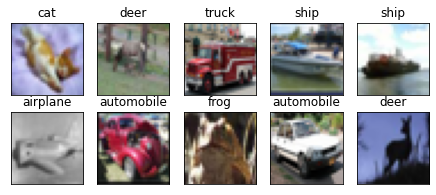

In [7]:
# Display images
import random
start = random.randint(0,49990)
to = start + 10
X = tf.constant(cifar10_train[0][start:to])
y = tf.constant(cifar10_train[1][start:to])
show_images(X, 2, 5, titles=get_cifar10_labels(y))

## Prepare and normalize Dataset for model

In [8]:
def prep_dataset():

  cifar10_train, cifar10_test = cifar10.load_data()
  # convert into float
  trainX = cifar10_train[0].astype('float')
  testX = cifar10_test[0].astype('float')

  # Normalize the data between 0 to 1
  trainX_n = trainX / 255
  testX_n = testX / 255

  #One hot encoding on target variable
  trainY_n = to_categorical(cifar10_train[1])   
  testY_n = to_categorical(cifar10_test[1])

  return trainX_n , trainY_n, testX_n, testY_n

## Define VGG Architecture

In [9]:
# Define VGG Net
def VGG_net():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPool2D(pool_size=2, strides=2))
  model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPool2D(pool_size=2, strides=2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # Compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics =['accuracy'])

  return model

In [10]:
model = VGG_net()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

C:\Users\Mira\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


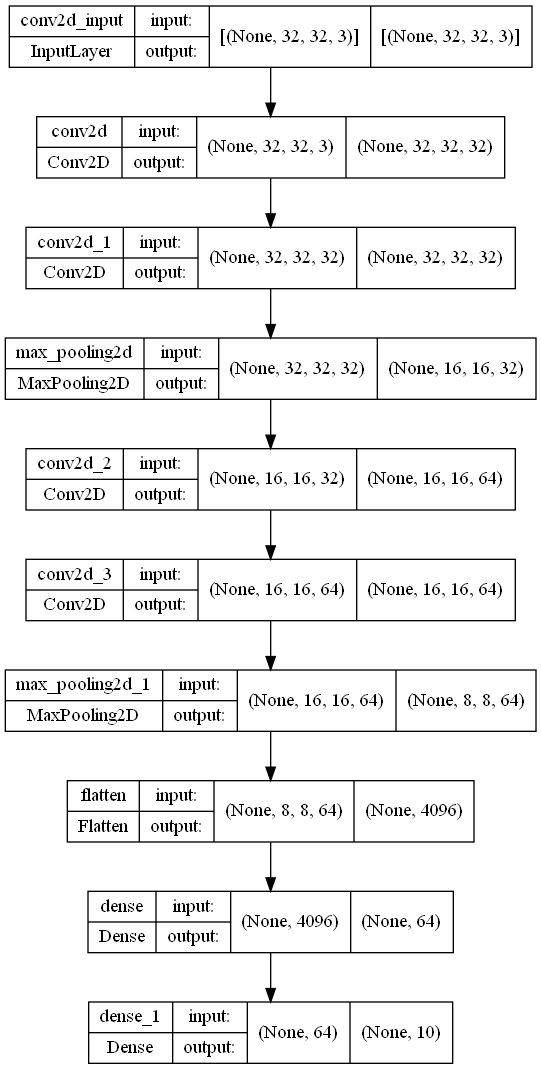

In [11]:
tf.keras.utils.plot_model(model=model, to_file='Baseline_model_plot.png', show_shapes=True)

## Fit the model

In [ ]:
# Fit model 
with tf.device('/device:GPU:0'):
  trainX, trainY, testX, testY = prep_dataset()

  # history = model.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=1)
  history = model.fit(trainX, trainY, epochs=10, validation_data=(testX, testY), verbose=1)

Epoch 1/10
1345/1563 [========================>.....] - ETA: 18s - loss: 1.7200 - accuracy: 0.3821

In [13]:
test_loss, test_acc = model.evaluate(testX, testY, verbose=1)

print('> %.3f' %(test_acc * 100))

313/313 [==============================] - 6s 19ms/step - loss: 0.8729 - accuracy: 0.7116
> 71.160


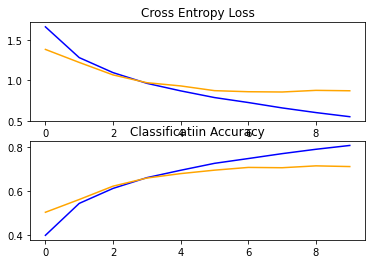

In [14]:
# Summarize and plot
def summarize(history):
  #Plot loss 
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label = 'Train')
  plt.plot(history.history['val_loss'], color='orange', label = 'Test')
  #Plot loss 
  plt.subplot(212)
  plt.title('Classificatiin Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label = 'Train')
  plt.plot(history.history['val_accuracy'], color='orange', label = 'Test')


summarize(history)